In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchinfo import summary
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from unet_network import UNet

pl.seed_everything(9999)

Global seed set to 9999


9999

In [2]:
#lake mask
mask_random_dir = "data/lakes_random/"
mask_random_paths = os.listdir(mask_random_dir)

mask_random_list = []

for i in mask_random_paths:
    lake_path = mask_random_dir+i
    lake_array = cv2.imread(lake_path, cv2.IMREAD_UNCHANGED)
    lake_array_float = lake_array.astype("float32") / 255.0
    mask_random_list.append(lake_array_float)


In [3]:
data = np.load("data/data.npz")
dem_data = data["dem"]


In [4]:
train = dem_data[:8000]
valid = dem_data[8000:]

In [5]:
valid_mask = np.stack(random.choices(mask_random_list, k=valid.shape[0]))

In [6]:
class DEMTrain(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks
                
        self.dem_transform = A.Compose([
            A.RandomRotate90(p=0.33),
            A.Flip(p=0.33),
            A.RandomResizedCrop(p=0.33, height=256, width=256, scale=(0.5, 1), interpolation=cv2.INTER_LINEAR)
        ])
        
        self.mask_transform = A.Compose([
            A.ShiftScaleRotate(p=0.33, scale_limit=0.2, shift_limit=0.2,
                               interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT),
            A.RandomRotate90(p=0.33),
            A.Flip(p=0.33)
        ])

    def __getitem__(self, idx):

        target = self.array[idx]
        target_transformed = self.dem_transform(image=target)
        target_trans = target_transformed["image"]
        target_tensor = torch.from_numpy(target_trans).unsqueeze(0)
        
        mask = random.choice(self.masks)
        mask_transformed = self.mask_transform(image=mask)
        mask_trans = mask_transformed["image"]
        mask_tensor = torch.from_numpy(mask_trans).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [7]:
class DEMValid(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks

    def __getitem__(self, idx):

        target = self.array[idx]
        target_tensor = torch.from_numpy(target).unsqueeze(0)
        
        mask = self.masks[idx]
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [8]:
train_dataset = DEMTrain(train, mask_random_list)
valid_dataset = DEMValid(valid, valid_mask)


(256, 256)
float32
0.66518885
0.0


<Figure size 432x288 with 0 Axes>

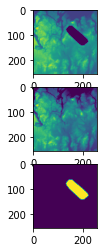

In [9]:
#Example
tmp_in, tmp_target, tmp_mask = train_dataset[0]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

print(tmp_in_np.shape)
print(tmp_in_np.dtype)
print(tmp_in_np.max())
print(tmp_in_np.min())

<Figure size 432x288 with 0 Axes>

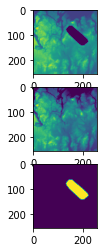

In [10]:
tmp_in_val, tmp_target_val, tmp_mask_val = valid_dataset[5]

tmp_in_val_np = tmp_in.squeeze().numpy()
tmp_target_val_np = tmp_target.squeeze().numpy()
tmp_mask_val_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_val_np)
axarr[1].imshow(tmp_target_val_np)
axarr[2].imshow(tmp_mask_val_np)


In [11]:
#Loss functions 

class MSELossWeighted(nn.Module):
    def __init__(self, w_hole = 10, w_nonhole = 1):
        super().__init__()
        self.l2 = nn.MSELoss()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole

    def forward(self, hat, obs, mask):
        
        l2_hole = self.l2(hat * mask, obs * mask)
        l2_nonhole = self.l2(hat * (1-mask), obs * (1-mask))
        
        l2_total = (l2_hole*self.w_hole) + (l2_nonhole*self.w_nonhole)

        return l2_total
    
class LOGMSELoss(nn.Module):
    def __init__(self, eps = 1):
        super().__init__()
        self.eps = eps

    def forward(self, hat, obs, mask):
        
        loss = torch.log(torch.abs(hat - obs) + self.eps).mean()

        return loss
    
class LOGMSELossWeighted(nn.Module):
    def __init__(self, w_hole = 5, w_nonhole = 1, eps = 1):
        super().__init__()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole
        self.eps = eps

    def forward(self, hat, obs, mask):
        
        loss_hole = torch.log(torch.abs((hat * mask) - (obs * mask)) + self.eps).mean()
        loss_nonhole = torch.log(torch.abs((hat * (1-mask)) - (obs * (1-mask))) + self.eps).mean()
        
        loss_total = (loss_hole*self.w_hole) + (loss_nonhole*self.w_nonhole)

        return loss_total
    

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true, mask):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred*mask
        y_true = y_true*mask
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1. - dsc

In [12]:
class AutoEncoder(pl.LightningModule):
    def __init__(self, init_features = 8, lr = 1e-4, loss = "mse"):
        super().__init__()
        
        self.save_hyperparameters()
                
        self.lr = lr
        
        self.unet = UNet(in_channels=1, out_channels=1, init_features=init_features)
        
        if loss == "mse":
            self.loss = MSELossWeighted()
        elif loss == "logmse":
            self.loss = LOGMSELossWeighted()
        elif loss == "dice":
            self.loss = DiceLoss()

    def forward(self, x):
        x_hat = self.unet(x)
        return x_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_in, x_obs, x_mask = train_batch
        x_hat=self.unet(x_in)
        loss = self.loss(x_hat, x_obs, x_mask)
        self.log('train_loss', loss, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
        x_in, x_obs, x_mask = val_batch
        x_hat = self.unet(x_in)
        loss = self.loss(x_hat, x_obs, x_mask)
        mse = F.mse_loss(x_hat, x_obs)
        self.log('val_loss', loss, on_epoch=True),
        self.log('val_mse', mse, on_epoch=True)


In [13]:

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=0)
val_loader = DataLoader(valid_dataset, batch_size=64, num_workers=0)

In [19]:
#Notes:

#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
#trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss")])

#load weights
#model = MyLightingModule.load_from_checkpoint(PATH)

#resume training from checkpoint
#trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")


#tensorboard --logdir=lightning_logs/


In [14]:

model = AutoEncoder(init_features=8, loss="mse", lr=1e-4)


In [15]:

checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_last=True)

trainer = pl.Trainer(gpus=1, max_epochs=300, callbacks=[checkpoint_callback], precision=16)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 9999
/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /media/kenneth/d6c13395-8492-49ee-9c0f-6a165e34c95c/autoencoder-for-lake-bathymetry/lr_find_temp_model_23122798-2655-4e44-acc4-51afb906f305.ckpt
/tmp/ipykernel_8909/149941112.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


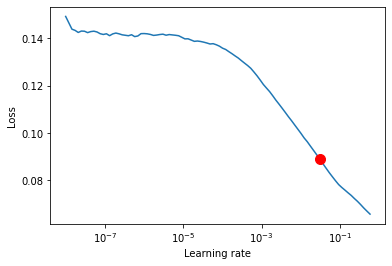

In [16]:
#lr finder
lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader)

fig = lr_finder.plot(suggest=True)

fig.show()

new_lr = lr_finder.suggestion()

model.hparams.lr = new_lr


In [23]:
new_lr

0.012022644346174132

In [24]:
trainer.fit(model, train_loader, val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type               | Params
--------------------------------------------
0 | unet | UNet               | 486 K 
1 | loss | LOGMSELossWeighted | 0     
--------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
0.973     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 9999


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
#trainer_2 = pl.Trainer(gpus=1, max_epochs=300, 
#                     callbacks=[checkpoint_callback],
#                    resume_from_checkpoint="lightning_logs/version_0/checkpoints/last.ckpt")


In [ ]:
#trainer_2.fit(model, train_loader, val_loader)


In [25]:
model_example = AutoEncoder.load_from_checkpoint("lightning_logs/version_21/checkpoints/epoch=80-step=10124.ckpt")

<Figure size 1200x800 with 0 Axes>

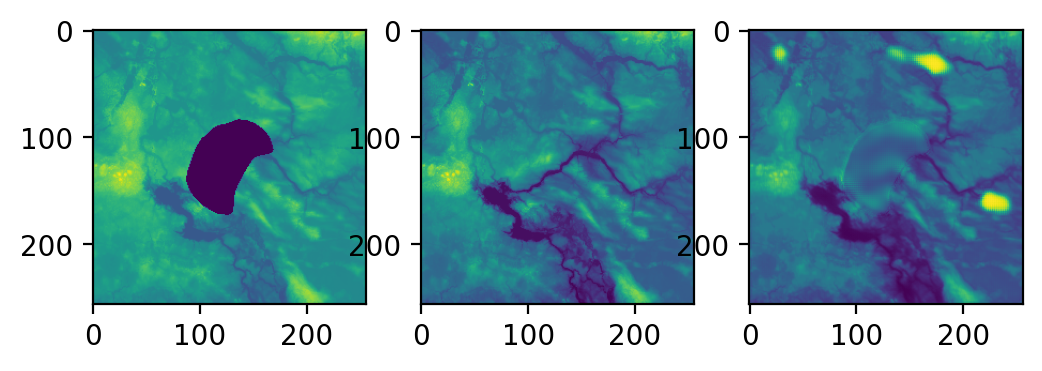

In [26]:
plt.rcParams['figure.dpi'] = 200

tmp_in, tmp_target, tmp_mask = valid_dataset[100]

with torch.no_grad():
    tmp_hat_np = model_example(tmp_in.unsqueeze(0))
    
tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()
tmp_hat_np = tmp_hat_np.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(1,3)
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_hat_np)
#axarr[3].imshow(tmp_target_np * tmp_mask_np)
#axarr[4].imshow(tmp_hat_np * tmp_mask_np)


In [13]:
train_transform = A.Compose([
    #A.RandomResizedCrop(p=0.5, height=256, width=256, scale=(0.5, 1), interpolation=cv2.INTER_LINEAR),
    #A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_LINEAR, rotate_limit=0),
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5)
])

In [14]:
#rescale range to 0-1 with approximate min-max
def dem_scale(dem, min_val=-25, max_val=175):
    return((dem - min_val)/(max_val - min_val))

def dem_inv_scale(dem_scale, min_val=-25, max_val=175):
    return(dem_scale*(max_val - min_val)+min_val)
  

In [15]:
#dataset for lakes data

class Lakes(Dataset):

    def __init__(self, lakes_list, transform = None):
      
        self.lakes_list = lakes_list
        self.transform = transform

    def __getitem__(self, idx):
        
        item = self.lakes_list[idx]
        lake = item["lake"]
        mask = item["mask"]
        
        lake = dem_scale(lake)

        if self.transform is not None:
            arrays_trans = self.transform(image=lake, mask = mask)
            lake = arrays_trans["image"]
            mask = arrays_trans["mask"]
        
        target_tensor = torch.from_numpy(lake).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor * (1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return len(self.lakes_list)

In [16]:
#import dict
#original dims in profile
import pickle
with open('data/lakes_16.pickle', 'rb') as src:
    lakes_list = pickle.load(src)

In [17]:
train_len = int(len(lakes_list)*0.6)
valid_len = int(len(lakes_list)*0.2)
test_len = int(len(lakes_list)*0.2)

print(train_len+valid_len+test_len)

225


In [18]:
random.shuffle(lakes_list)
train_list = lakes_list[:train_len]
valid_list = lakes_list[train_len:(train_len+valid_len)]
test_list = lakes_list[(train_len+valid_len):(train_len+valid_len+test_len)]

print(len(train_list)+len(valid_list)+len(test_list))

225


In [19]:
train_ds = Lakes(train_list, train_transform)
valid_ds = Lakes(valid_list)
test_ds = Lakes(test_list)

<Figure size 432x288 with 0 Axes>

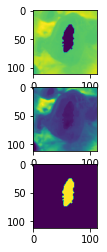

In [20]:
tmp_in, tmp_target, tmp_mask = train_ds[2]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

In [ ]:
#How to train network with different size input? (all divisible by 16)

In [21]:
def collate_variable_sized_img(batch):
    input_tensor = [item[0] for item in batch]
    target_tensor = [item[1] for item in batch]
    mask_tensor = [item[2] for item in batch]
    return [input_tensor, target_tensor, mask_tensor]

In [22]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_variable_sized_img)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=4, collate_fn=collate_variable_sized_img)
test_dl = DataLoader(test_ds, batch_size=16, num_workers=4, collate_fn=collate_variable_sized_img)

In [23]:
lake_model = AutoEncoder.load_from_checkpoint("lightning_logs/version_21/checkpoints/epoch=80-step=10124.ckpt")


In [24]:
lake_model.hparams.lr = 1e-3

In [25]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_last=True) 

trainer = pl.Trainer(gpus=1,  
                     max_epochs=200,
                     callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [26]:

trainer.fit(lake_model, train_dl, valid_dl)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 486 K 
1 | loss | MSELossWeighted | 0     
-----------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


In [60]:
lake_model = AutoEncoder.load_from_checkpoint("lightning_logs/version_11/checkpoints/epoch=199-step=1799.ckpt")

In [ ]:
tmp_in, tmp_target, tmp_mask = valid_ds[20]

with torch.no_grad():
    tmp_hat_np = lake_model(tmp_in.unsqueeze(0))
    
tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()
tmp_hat_np = tmp_hat_np.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(1,4)
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np*tmp_mask_np)
axarr[2].imshow(tmp_hat_np*tmp_mask_np)
axarr[3].imshow((tmp_hat_np*tmp_mask_np)-(tmp_target_np*tmp_mask_np))

In [62]:
#obs = [i["lake"] * i["mask"] for i in valid_list]
def nan_for_mask(item):
    lake = item["lake"]
    mask = item["mask"]
    
    lake_copy = lake.copy()
    
    lake_copy[mask == 0] = np.nan
    
    return(lake_copy)
    
obs = [nan_for_mask(i) for i in valid_list]

In [ ]:
plt.imshow(obs[0])

In [64]:
def predict_func(x):
    
    lake = dem_scale(x["lake"])
    mask = x["mask"]
    
    target_tensor = torch.from_numpy(lake).unsqueeze(0)
    mask_tensor = torch.from_numpy(mask).unsqueeze(0)
    input_tensor = target_tensor * (1-mask_tensor)
    
    with torch.no_grad():
        xhat_tensor = lake_model(input_tensor.unsqueeze(0))
        
    xhat_np = xhat_tensor.squeeze().numpy()
    xhat_np_orig_scale = dem_inv_scale(xhat_np)
    #xhat_mask = xhat_np_orig_scale*mask
    xhat_np_orig_scale[mask == 0] = np.nan
    
    return(xhat_np_orig_scale)
    

In [65]:
pred = [predict_func(i) for i in valid_list]

In [ ]:
plt.imshow(pred[1])

In [67]:
lake_obs_mean = [np.nanmean(i) for i in obs]
lake_pred_mean = [np.nanmean(i) for i in pred]



In [ ]:
obs_np = np.array(lake_obs_mean)
pred_np = np.array(lake_pred_mean)

np.sqrt(np.mean((obs_np-pred_np)**2))

In [ ]:
plt.plot(lake_obs_mean,lake_pred_mean,'r.') # x vs y
plt.plot(lake_obs_mean,lake_obs_mean,'k-') # identity line

plt.xlabel("obs")
plt.ylabel("pred")
plt.show()

In [ ]:
corr_list = [np.corrcoef(o.flatten, p.flatten) for o, p in zip(obs, pred)]
corr_list